Imports

In [ ]:
!pip install timm
!pip install transformers

In [ ]:
from IPython import display as ipythondisplay
from torch import nn
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as A
import cv2
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import timm
import torch
import torch.nn.functional as F

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


## Some pre-preocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/Shareddrives/DeepLearning/datav2/dataset.csv')

Mounted at /content/drive


In [ ]:

# Ops to consolidate dataset to the notebook standards

# Create a compound column using other columns. Comment lines for less or more complexity

# "a sagital plane
# MR scan
# of cranial trauma
# on a 58 year old male
# diagnosed with brain death
df["grouped_diag"] = df.apply(lambda row: \
                              "a " + str(row.Plane) + " plane "\
                              + str(row.Core_Modality) + " scan"\
                              + " of "  + str(row.Location) + " " + str(row.Category)\
                              + " on a " + str(row.Patient_Age) + " year old " + str(row.Patient_Gender)
                              + " depicting "+ str(row.Case_Diagnosis)
                              , axis = 1)


#  reformat to fit the shape
#  	image 	caption id
df.rename(columns={"filename":"image", "grouped_diag":"caption"},inplace=True)
needed_cols = ["image","caption"]
df = df[df.columns.intersection(needed_cols)]

image_path = "/content/drive/Shareddrives/DeepLearning/datav2/output"
captions_path = "/content/drive/Shareddrives/DeepLearning/datav2"

#  	image 	caption
# 0 	1000268201_693b08cb0e.jpg 	A child in a pink dress is climbing up a set o...
# 1 	1000268201_693b08cb0e.jpg 	A girl going into a wooden building .
# 2 	1000268201_693b08cb0e.jpg 	A little girl climbing into a wooden playhouse .
# 3 	1000268201_693b08cb0e.jpg 	A little girl climbing the stairs to her playh...
# 4 	1000268201_693b08cb0e.jpg 	A little girl in a pink dress going into a woo...

# I have no idea why tf he writes the dataset to memory but whatev
df.to_csv(captions_path + "/captions.csv", index=False)

df.head()

,image,caption
0,synpic100377.jpg,a Multiple or Montage plane CT scan of Musculo...
1,synpic100378.jpg,a Multiple or Montage plane CT scan of Musculo...
2,synpic100379.jpg,a Multiple or Montage plane CT scan of Musculo...
3,synpic100380.jpg,a Oblique plane XR scan of Musculoskeletal Tra...
4,synpic100381.jpg,a Multiple or Montage plane MR scan of Musculo...


In [ ]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 12
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    saved_model_clinical = '/content/drive/Shareddrives/DeepLearning/datav2/withDiagnostics2.pt'
    trained_model = 'clinical_bert_weights.pt'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    clinical_encoder_model = "emilyalsentzer/Bio_ClinicalBERT"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

In [ ]:
from sklearn.model_selection import train_test_split

def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    train, test = train_test_split(dataframe, test_size=.1, train_size=.9, shuffle=True, random_state=77,stratify=None)
    return train, test

testing_df , training_df = make_train_valid_dfs()

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

In [ ]:
# Custom dataset object. Will tokenize text and apply transforms to images before yielding them.

class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.skippedImgCount = 0
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        ################################
        # MASSIVE GDRIVE BUG HERE
        # Sometimes, reading an image from disk fails, which crashes the entirety of the program
        # Here we default to adding the image at dataset[0]
        ################################
        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        if image is None:
          self.skippedImgCount += 1
          return self.__getitem__(1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )



## Image Encoder

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            # self.model = DistilBertModel.from_pretrained(model_name)

            # Use Bio-ClinicalBERT
            self.model = AutoModel.from_pretrained(CFG.clinical_encoder_model)

        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [ ]:
# Get both image and text encodings into a same size matrix
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

The perfect relationship between encoded images and captions is described by their encoded representations being the same.
This similarity can easily be measured by looking at the softmax between the dot product of the encoded inputs; a perfect encoding will yield the identity matrix.
The loss on each iteration is calculated using cross entropy on the dot product between the encodings.

In [ ]:
# A simple Example


batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


## Train

In [ ]:


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [ ]:

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)

      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    history = []
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)


        loss_meter.update(loss.item(), count)

        history.append(loss.cpu().detach().numpy().mean())

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    plotter.plot(history)
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter





def main():
    train_df = training_df
    valid_df = testing_df
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')

    history = []
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        torch.save(model.state_dict(), "temp.pt")
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)
    print(f"CAREFUL! I had to skip {train_loader.dataset.skippedImgCount} to finish. This introduces heavy bias to whatever dataset[0] was at the time of training")


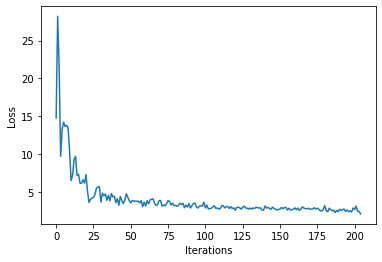

  0%|          | 0/1843 [00:00<?, ?it/s]

In [ ]:
# Run to start training
main()